<a href="https://colab.research.google.com/github/matthew-balogh/bdsc/blob/main/overview-of-statistical-learning/overview-of-statistical-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Income Relationship

Synthetically generated relationship between predictors of `Education`, `Seniority` and response of `Income`. Each predictor individually exhibits a non-linear, sigmoid shape and independently and additively contributes to `Income`.

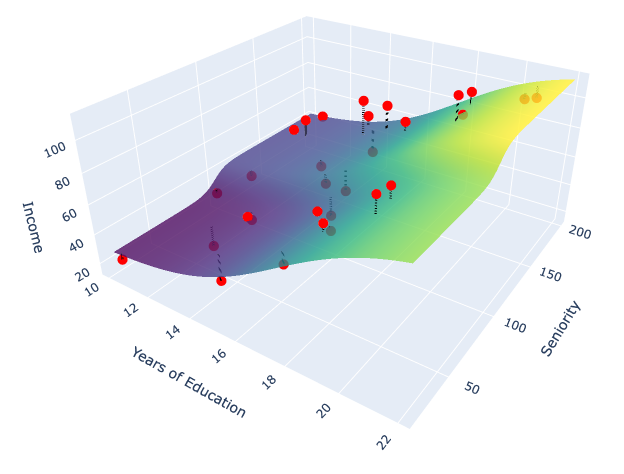

## Imports and settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures

In [2]:
np.random.seed(42)

## Synthetic relationship

A synthetic dataset of `IncomeSynthetic` is created which includes the predictors (`education`, `seniority`), their respective income values (`income_ed`, `income_sen`) considered as observations diluted with noise, the respective income values from the true and noiseless relationship (`income_ed_true`, `income_sen_true`) known due to synthetic generation, along with the additive income values (`income`, `income_true`).

### Generating the relationship

In [3]:
# helpers

def sigmoid(x, beta=1, center=0):
    return 1 / (1 + np.exp(-beta * (x - center)))

def bounded_sigmoid(x, beta=1, center=0, a=0, b=1):
    raw_sigmoid = sigmoid(x, beta, center)
    return a + (b - a) * raw_sigmoid

def individual_relationship_f(x, b, c, ymin, ymax):
    return bounded_sigmoid(x, b, c, ymin, ymax)

def combined_relationship_f(x1, x2):
    f1 = individual_relationship_f(x1, ed_beta_0, ed_center, ed_y_min, ed_y_max)
    f2 = individual_relationship_f(x2, sen_beta_0, sen_center, sen_y_min, sen_y_max)
    return f1 + f2

In [4]:
# details

n = 30

## Education
ed_y_min, ed_y_max = 20, 100
ed_beta_0, ed_center = 0.5, 17.5
ed_x_min, ed_x_max = 10, 22
ed_noise_sigma = 10

## Seniority
sen_y_min, sen_y_max = 5, 20
sen_beta_0, sen_center = 0.2, 100
sen_x_min, sen_x_max = 20, 200
sen_noise_sigma = 3

### Bivariate scenario

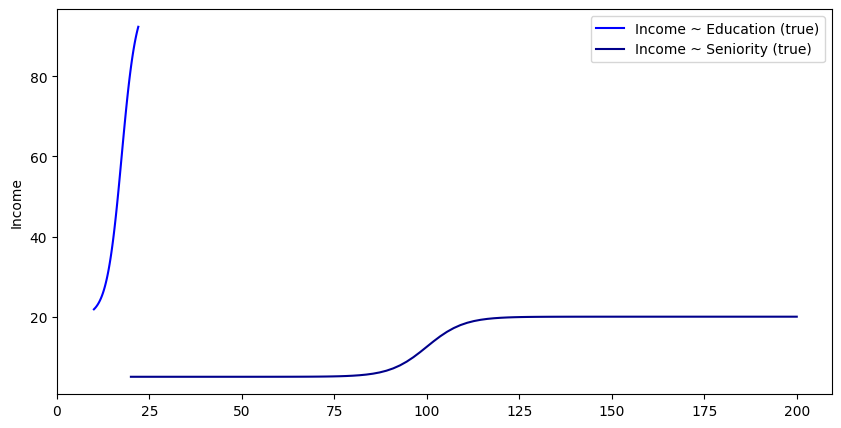

In [5]:
#@title #### Individual contributions

plt.figure(figsize=(10, 5))

xspace = np.linspace(ed_x_min, ed_x_max, 100)
y_true = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

plt.plot(xspace, y_true, c="blue", label="Income ~ Education (true)")

xspace = np.linspace(sen_x_min, sen_x_max, 100)
y_true = individual_relationship_f(xspace, sen_beta_0, sen_center, sen_y_min, sen_y_max)

plt.plot(xspace, y_true, c="darkblue", label="Income ~ Seniority (true)")

plt.ylabel("Income")
plt.xlim(left=0)
plt.legend()

plt.show()

In [6]:
#@title #### Combined contribution

x1, x2 = np.linspace(ed_x_min, ed_x_max, 100), np.linspace(sen_x_min, sen_x_max, 100)
X1, X2 = np.meshgrid(x1, x2)

col_relationship1, col_relationship2 = 'cornflowerblue', 'blue'
surface_opacity = 0.75
surface_color_scale = [[0, col_relationship1], [1, col_relationship2]]

Y_true = combined_relationship_f(X1, X2)

true_surface = go.Surface(x=X1, y=X2, z=Y_true,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

fig = go.Figure()
fig.add_trace(true_surface)

scene_setup = dict(
    xaxis_title='Years of Education',
    yaxis_title='Seniority',
    zaxis_title='Income',
    aspectmode="manual",
    aspectratio=dict(x=1, y=1, z=0.5),
    camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-1.5, z=1)
    )
)

fig.update_layout(
    scene=scene_setup,
    width = 750,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

### Univariate scenario

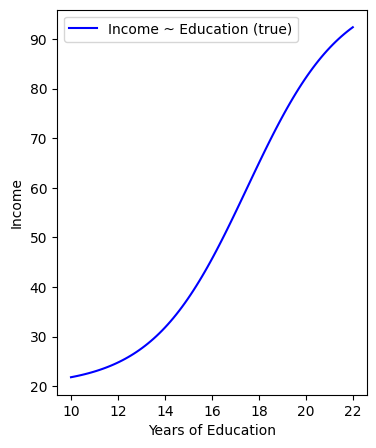

In [7]:
#@title #### Single contributor

fig = plt.figure(figsize=(4, 5))

xspace = np.linspace(ed_x_min, ed_x_max, 100)
y_true = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

plt.plot(xspace, y_true, c="blue", label="Income ~ Education (true)")

plt.xlabel("Years of Education")
plt.ylabel("Income")
plt.legend()

plt.show()

## Observation datasets

Construct two datasets where only the naturally observable variables and values are present. One where the individual predictors `education` and `seniority` additively contribute to the income, to be referred to as the `Income` dataset. In the second one, only `education` makes a contribution, to be referred to as the `IncomeSimple`.

In [8]:
education = np.random.uniform(ed_x_min, ed_x_max, n)
seniority = np.random.uniform(sen_x_min, sen_x_max, n)

ed_noise = np.random.normal(0, ed_noise_sigma, size=n)
sen_noise = np.random.normal(0, sen_noise_sigma, size=n)

income = combined_relationship_f(education, seniority) + ed_noise + sen_noise

Income = pd.DataFrame({
    'education': education,
    'seniority': seniority,
    'income': income
})

income_simple = individual_relationship_f(education, ed_beta_0, ed_center, ed_y_min, ed_y_max) + ed_noise

IncomeSimple = pd.DataFrame({
    'education': education,
    'income': income_simple
})

#### `Income`

In [9]:
Income.describe()

education   seniority      income
count  30.000000   30.000000   30.000000
mean   15.263167  109.352768   58.910305
std     3.388890   59.238784   24.764013
min    10.247014   26.189934   20.932506
25%    12.249662   53.774580   36.432161
50%    14.838911  111.372044   58.143201
75%    17.310021  164.014619   79.798053
max    21.638918  194.525233  116.759390

In [10]:
Income.head()

education   seniority     income
0  14.494481  129.358073  31.874537
1  21.408572   50.694342  90.341105
2  18.783927   31.709287  73.070548
3  17.183902  190.799397  86.519782
4  11.872224  193.813766  48.237728

#### `IncomeSimple`

In [11]:
IncomeSimple.describe()

education      income
count  30.000000   30.000000
mean   15.263167   46.517169
std     3.388890   23.432158
min    10.247014    6.895243
25%    12.249662   28.177567
50%    14.838911   41.039375
75%    17.310021   67.199709
max    21.638918  100.344732

In [12]:
IncomeSimple.head()

education     income
0  14.494481  19.775928
1  21.408572  82.874615
2  18.783927  67.809389
3  17.183902  67.416804
4  11.872224  27.962446

## `IncomeSimple` dataset

The data is displayed in its original scale. Besides the sampled observations that are diluted with zero-mean noise, the true underlying non-linear (synthetic) relationship is highlighted along with the residual lines.

In [13]:
# helper functions

def plot_scatter(x, y, ax, s=20, c="r", label=None):
    ax.scatter(x, y, s=s, c=c, label=label)

def plot_true_function(xspace, true_f, ax, c="b", label=None):
    ax.plot(xspace, true_f, c=c, label=label)

def draw_residual_lines(x, y_obs, y_true, ax, alpha=0.75, color="black"):
    for x_i, y_obs_i, y_true_i in zip(x, y_obs, y_true):
        ax.vlines(x_i, min(y_obs_i, y_true_i), max(y_obs_i, y_true_i), linestyles='dashed', colors=color, alpha=alpha)

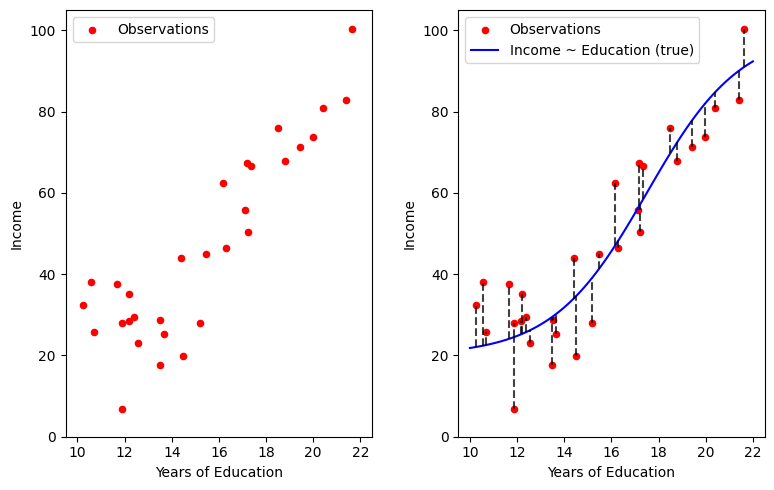

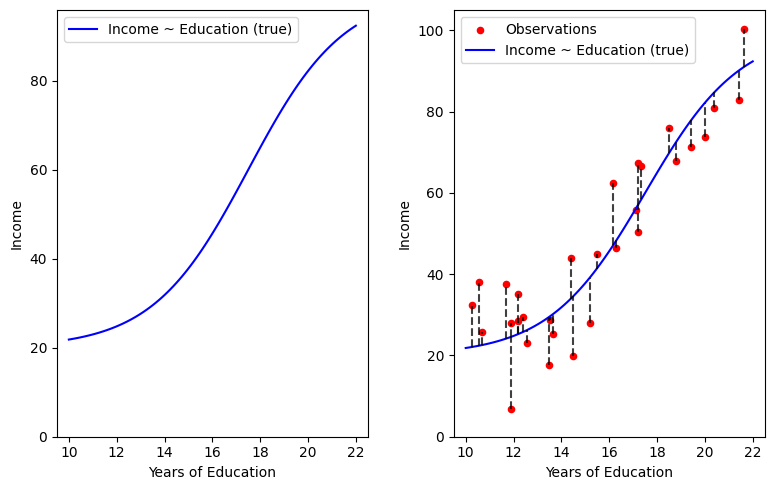

In [14]:
#@title Observations and true relationship

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

x = IncomeSimple['education']
y_obs = IncomeSimple['income']

y_true = individual_relationship_f(x, ed_beta_0, ed_center, ed_y_min, ed_y_max)

xspace = np.linspace(ed_x_min, ed_x_max, 100)
y_f = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

# left
ax = axes[0]
plot_scatter(x, y_obs, ax, label="Observations")

# right
ax = axes[1]
plot_scatter(x, y_obs, ax, label="Observations")
plot_true_function(xspace, y_f, ax, label="Income ~ Education (true)")
draw_residual_lines(x, y_obs, y_true, ax)

for ax in axes:
    ax.set_xlabel("Years of Education")
    ax.set_ylabel("Income")
    ax.set_xlim([ed_x_min - 0.5, ed_x_max + 0.5])
    ax.set_ylim(bottom=min(0, ax.get_ylim()[0]))
    ax.legend()

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# left
ax = axes[0]
plot_true_function(xspace, y_f, ax, label="Income ~ Education (true)")

# right
ax = axes[1]
plot_scatter(x, y_obs, ax, label="Observations")
plot_true_function(xspace, y_f, ax, label="Income ~ Education (true)")
draw_residual_lines(x, y_obs, y_true, ax)

for ax in axes:
    ax.set_xlabel("Years of Education")
    ax.set_ylabel("Income")
    ax.set_xlim([ed_x_min - 0.5, ed_x_max + 0.5])
    ax.set_ylim(bottom=min(0, ax.get_ylim()[0]))
    ax.legend()

plt.tight_layout()
plt.show()

## `Income` dataset

The data is displayed in its original scale. Besides the sampled observations that are diluted with zero-mean noise, the true underlying non-linear (synthetic) relationship is highlighted along with the residual lines.

In [15]:
#@title Observations and true relationship

x1, x2 = np.linspace(ed_x_min, ed_x_max, 100), np.linspace(sen_x_min, sen_x_max, 100)
X1, X2 = np.meshgrid(x1, x2)

col_relationship1, col_relationship2 = 'cornflowerblue', 'blue'
surface_opacity = 0.75
surface_color_scale = [[0, col_relationship1], [1, col_relationship2]]

Y_obs = go.Scatter3d(x=Income['education'], y=Income['seniority'], z=Income['income'],
    mode='markers', marker=dict(size=6, color='red', opacity=1), showlegend=False)

Y_true = combined_relationship_f(Income['education'], Income['seniority'])
Y_ff = combined_relationship_f(X1, X2)

true_surface = go.Surface(x=X1, y=X2, z=Y_ff,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

residual_lines = []
for idx, row in Income.iterrows():
    residual_lines.append(
        go.Scatter3d(
            x=[row['education'], row['education']],
            y=[row['seniority'], row['seniority']],
            z=[row['income'], Y_true.iloc[idx]],
            mode='lines', line=dict(color='black', width=5, dash='dash'), showlegend=False))

fig = make_subplots(rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    horizontal_spacing=0, vertical_spacing=0
)

# left
fig.add_trace(Y_obs, row=1, col=1)

# right
fig.add_trace(Y_obs, row=1, col=2)
fig.add_trace(true_surface, row=1, col=2)

for line in residual_lines:
    fig.add_trace(line, row=1, col=2)

scene_setup = dict(
    xaxis_title="Years of Education",
    yaxis_title="Seniority",
    zaxis_title="Income",
    aspectmode="manual",
    aspectratio=dict(x=1, y=1, z=0.5),
    camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-1.5, z=1)
    )
)

fig.update_layout(
    scene=scene_setup,
    scene2=scene_setup,
    width = 1350,
    height = 600,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

## Estimating the Relationship

Establish various estimators from simple *linear* through *polynomials* to *splines*. Plot them individually along with the true relationship included in each.

In [16]:
# preparation

featuresPoly = {
    "2": [None, None],
    "3": [None, None],
}

estimators = {
    "Linear": [None, None],
    "Poly2": [None, None],
    "Poly3": [None, None],
    "Spline1": [None, None],
    "Spline2": [None, None],
    "Spline3": [None, None]
}

def sort_variables(x, y):
    sorted_x_indices = np.argsort(x.flatten())
    x_sorted = x.flatten()[sorted_x_indices].reshape(-1, 1)
    y_sorted = y.values[sorted_x_indices]
    return x_sorted, y_sorted

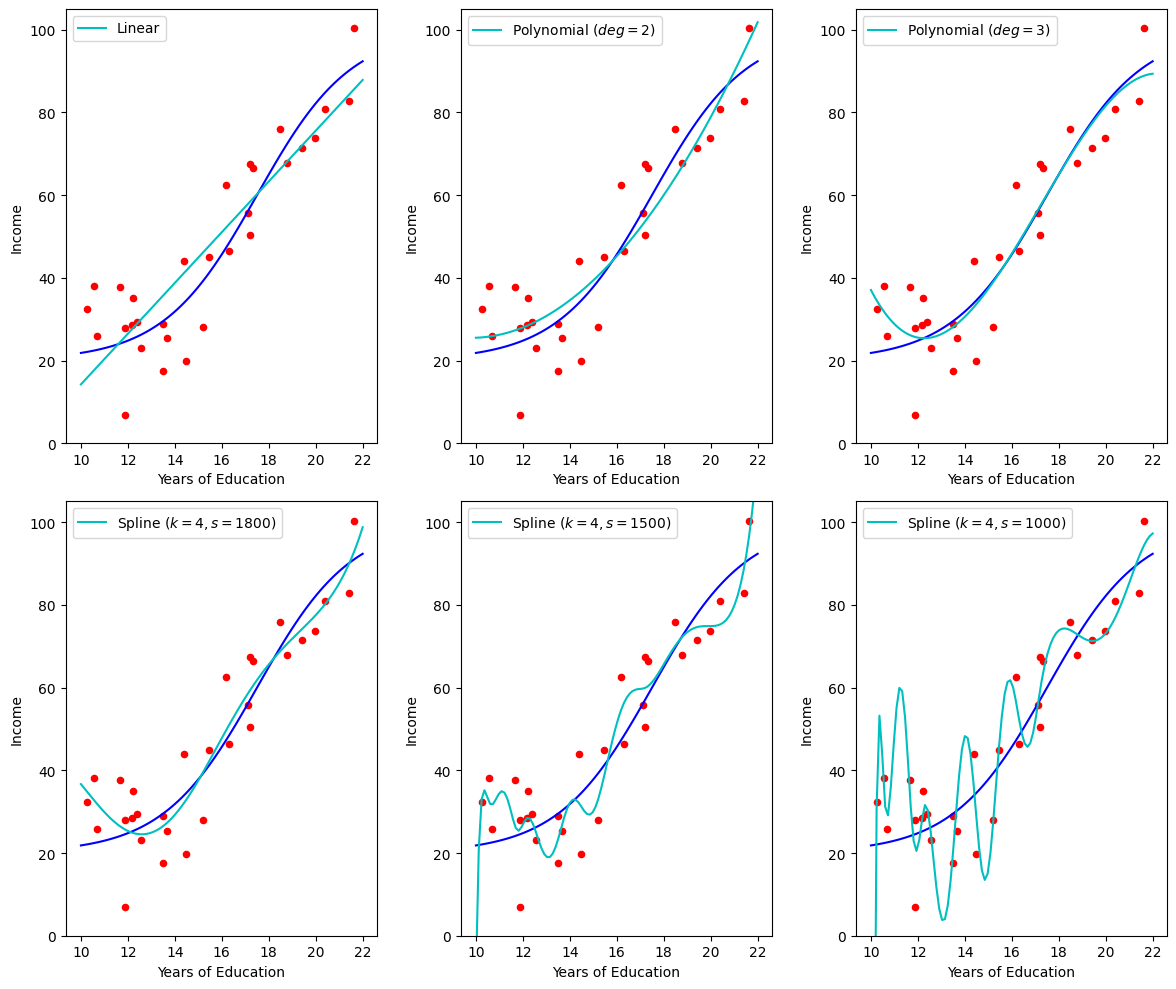

In [17]:
#@title ### `IncomeSimple`: `Income` ~ `Education`

fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

xspace = np.linspace(ed_x_min, ed_x_max, 100)
xspace_ = xspace.reshape(-1, 1)

x = IncomeSimple[['education']].values
y = IncomeSimple['income']

x_sorted, y_sorted = sort_variables(x, y)

color_estimator = "c"

# true relationship function
true_f = individual_relationship_f(xspace, ed_beta_0, ed_center, ed_y_min, ed_y_max)

# plot estimators in `xspace`

## linear model
modelLinear = LinearRegression().fit(x, y)
linear_f = modelLinear.predict(xspace_)

## polynomial, deg=2
featuresPoly2 = PolynomialFeatures(degree=2)
modelPoly2 = LinearRegression().fit(
    featuresPoly2.fit_transform(x),
    y
)
poly2_f = modelPoly2.predict(featuresPoly2.transform(xspace_))

## polynomial, deg=3
featuresPoly3 = PolynomialFeatures(degree=3)
modelPoly3 = LinearRegression().fit(
    featuresPoly3.fit_transform(x),
    y
)
poly3_f = modelPoly3.predict(featuresPoly3.transform(xspace_))

## splines (3 different)

k = 4
s1, s2, s3 = 1.8e3, 1.5e3, 1e3
spline1 = UnivariateSpline(x_sorted, y_sorted, k=k, s=s1)
spline2 = UnivariateSpline(x_sorted, y_sorted, k=k, s=s2)
spline3 = UnivariateSpline(x_sorted, y_sorted, k=k, s=s3)

spline1_f = spline1(xspace)
spline2_f = spline2(xspace)
spline3_f = spline3(xspace)

# store estimators

estimators["Linear"][0]=modelLinear

featuresPoly["2"][0]=featuresPoly2
estimators["Poly2"][0]=modelPoly2

featuresPoly["3"][0]=featuresPoly3
estimators["Poly3"][0]=modelPoly3

estimators["Spline1"][0]=spline1
estimators["Spline2"][0]=spline2
estimators["Spline3"][0]=spline3

# 1
ax = axes[0]
label = "Linear"
plot_scatter(x, y, ax)
plot_true_function(xspace, true_f, ax)
ax.plot(xspace, linear_f, c=color_estimator, label=label)
plot_ylim = ax.get_ylim()

# 2
ax = axes[1]
label = "Polynomial ($deg=2$)"
plot_scatter(x, y, ax)
plot_true_function(xspace, true_f, ax)
ax.plot(xspace, poly2_f, c=color_estimator, label=label)

# 3
ax = axes[2]
label = "Polynomial ($deg=3$)"
plot_scatter(x, y, ax)
plot_true_function(xspace, true_f, ax)
ax.plot(xspace, poly3_f, c=color_estimator, label=label)

# next row

# 1
ax = axes[3]
label = f"Spline ($k={k}, s={int(s1)})$"
plot_scatter(x, y, ax)
plot_true_function(xspace, true_f, ax)
ax.plot(xspace, spline1_f, c=color_estimator, label=label)

# 2
ax = axes[4]
label = f"Spline ($k={k}, s={int(s2)})$"
plot_scatter(x, y, ax)
plot_true_function(xspace, true_f, ax)
ax.plot(xspace, spline2_f, c=color_estimator, label=label)

# 3
ax = axes[5]
label = f"Spline ($k={k}, s={int(s3)})$"
plot_scatter(x, y, ax)
plot_true_function(xspace, true_f, ax)
ax.plot(xspace, spline3_f, c=color_estimator, label=label)

for ax in axes:
    ax.set_xlabel("Years of Education")
    ax.set_ylabel("Income")
    ax.set_ylim(plot_ylim)
    ax.set_xlim(left=ax.get_xlim()[0]-0.05)
    ax.set_ylim(bottom=min(0, ax.get_ylim()[0]))
    ax.legend()

plt.tight_layout()
plt.show()

del label, plot_ylim

In [18]:
# `Income` ~ `Seniority`

#fig, axes = plt.subplots(2, 3, figsize=(12, 10))
#axes = axes.flatten()

xspace = np.linspace(sen_x_min, sen_x_max, 100)
xspace_ = xspace.reshape(-1, 1)

dummy_df = pd.DataFrame({
    'seniority': Income['seniority'],
    'income': individual_relationship_f(Income['seniority'], sen_beta_0, sen_center, sen_y_min, sen_y_max) + sen_noise
})

x = dummy_df[['seniority']].values
y = dummy_df['income']

x_sorted, y_sorted = sort_variables(x, y)

color_estimator = "c"

# true relationship function
true_f = individual_relationship_f(xspace, sen_beta_0, sen_center, sen_y_min, sen_y_max)

## linear model
modelLinear = LinearRegression().fit(x, y)
linear_f = modelLinear.predict(xspace_)

## polynomial, deg=2
featuresPoly2 = PolynomialFeatures(degree=2)
modelPoly2 = LinearRegression().fit(
    featuresPoly2.fit_transform(x),
    y
)
poly2_f = modelPoly2.predict(featuresPoly2.transform(xspace_))

## polynomial, deg=3
featuresPoly3 = PolynomialFeatures(degree=3)
modelPoly3 = LinearRegression().fit(
    featuresPoly3.fit_transform(x),
    y
)
poly3_f = modelPoly3.predict(featuresPoly3.transform(xspace_))

## splines (3 different)

k = 4
s1, s2, s3 = 0.8e3, 1e2, 5e1
spline1 = UnivariateSpline(x_sorted, y_sorted, k=k, s=s1)
spline2 = UnivariateSpline(x_sorted, y_sorted, k=k, s=s2)
spline3 = UnivariateSpline(x_sorted, y_sorted, k=k, s=s3)

spline1_f = spline1(xspace)
spline2_f = spline2(xspace)
spline3_f = spline3(xspace)

# store estimators

estimators["Linear"][1]=modelLinear

featuresPoly["2"][1]=featuresPoly2
estimators["Poly2"][1]=modelPoly2

featuresPoly["3"][1]=featuresPoly3
estimators["Poly3"][1]=modelPoly3

estimators["Spline1"][1]=spline1
estimators["Spline2"][1]=spline2
estimators["Spline3"][1]=spline3

## 1
#ax = axes[0]
#label = "Linear"
#plot_scatter(x, y, ax)
#plot_true_function(xspace, true_f, ax)
#ax.plot(xspace, linear_f, c=color_estimator, label=label)
#plot_ylim = ax.get_ylim()
#
## 2
#ax = axes[1]
#label = "Polynomial ($deg=2$)"
#plot_scatter(x, y, ax)
#plot_true_function(xspace, true_f, ax)
#ax.plot(xspace, poly2_f, c=color_estimator, label=label)
#
## 3
#ax = axes[2]
#label = "Polynomial ($deg=3$)"
#plot_scatter(x, y, ax)
#plot_true_function(xspace, true_f, ax)
#ax.plot(xspace, poly3_f, c=color_estimator, label=label)
#
## next row
#
## 1
#ax = axes[3]
#label = f"Spline ($k={k}, s={int(s1)})$"
#plot_scatter(x, y, ax)
#plot_true_function(xspace, true_f, ax)
#ax.plot(xspace, spline1_f, c=color_estimator, label=label)
#
## 2
#ax = axes[4]
#label = f"Spline ($k={k}, s={int(s2)})$"
#plot_scatter(x, y, ax)
#plot_true_function(xspace, true_f, ax)
#ax.plot(xspace, spline2_f, c=color_estimator, label=label)
#
## 3
#ax = axes[5]
#label = f"Spline ($k={k}, s={int(s3)})$"
#plot_scatter(x, y, ax)
#plot_true_function(xspace, true_f, ax)
#ax.plot(xspace, spline3_f, c=color_estimator, label=label)
#
#for ax in axes:
#    ax.set_xlabel('Years of Education')
#    ax.set_ylabel('Income')
#    ax.set_ylim(plot_ylim)
#    ax.set_xlim(left=ax.get_xlim()[0])
#    ax.set_ylim(bottom=min(0, ax.get_ylim()[0]))
#    ax.legend()
#
#plt.tight_layout()
#plt.show()
#
#del label, plot_ylim

In [19]:
assert len(featuresPoly["2"]) == 2
assert len(featuresPoly["3"]) == 2

assert len(estimators["Linear"]) == 2
assert len(estimators["Poly2"]) == 2
assert len(estimators["Poly3"]) == 2
assert len(estimators["Spline1"]) == 2
assert len(estimators["Spline2"]) == 2
assert len(estimators["Spline3"]) == 2

In [20]:
#@title ### `Income`: `Income` ~ `Education` + `Seniority`

X = Income[['education', 'seniority']]
Y = Income['income']

x1, x2 = np.linspace(ed_x_min, ed_x_max, 100), np.linspace(sen_x_min, sen_x_max, 100)
X1, X2 = np.meshgrid(x1, x2)

col_estimator1, col_estimator2 = 'gold', 'orange'
surface_opacity = 0.75
surface_color_scale = [[0, col_estimator1], [1, col_estimator2]]

# observations
scatter_points = go.Scatter3d(
    x=X['education'],
    y=X['seniority'],
    z=Y,
    mode='markers',
    marker=dict(size=6, color='red', opacity=1),
    showlegend=False
)

# estimators

## linear model
linearModels = estimators["Linear"]
Y_hat = linearModels[0].predict(X1.reshape(-1, 1)) + linearModels[1].predict(X2.reshape(-1, 1))
Y_hat = Y_hat.reshape(X1.shape)

linear_surface = go.Surface(x=X1, y=X2, z=Y_hat,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

## polynomial, deg=2
poly2Features = featuresPoly["2"]
poly2FeaturesTransformed = [poly2Features[0].transform(X1.reshape(-1, 1)), poly2Features[1].transform(X2.reshape(-1, 1))]
poly2Models = estimators["Poly2"]
Y_hat = poly2Models[0].predict(poly2FeaturesTransformed[0]) + poly2Models[1].predict(poly2FeaturesTransformed[1])
Y_hat = Y_hat.reshape(X1.shape)

poly2_surface = go.Surface(x=X1, y=X2, z=Y_hat,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

## polynomial, deg=3
poly3Features = featuresPoly["3"]
poly3FeaturesTransformed = [poly3Features[0].transform(X1.reshape(-1, 1)), poly3Features[1].transform(X2.reshape(-1, 1))]
poly3Models = estimators["Poly3"]
Y_hat = poly3Models[0].predict(poly3FeaturesTransformed[0]) + poly3Models[1].predict(poly3FeaturesTransformed[1])
Y_hat = Y_hat.reshape(X1.shape)

poly3_surface = go.Surface(x=X1, y=X2, z=Y_hat,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

## splines (3 different)

spline1Models = estimators["Spline1"]
Y_hat = spline1Models[0](X1) + spline1Models[1](X2)

spline1_surface = go.Surface(x=X1, y=X2, z=Y_hat,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

spline2Models = estimators["Spline2"]
Y_hat = spline2Models[0](X1) + spline2Models[1](X2)

spline2_surface = go.Surface(x=X1, y=X2, z=Y_hat,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

spline3Models = estimators["Spline3"]
Y_hat = spline3Models[0](X1) + spline3Models[1](X2)

spline3_surface = go.Surface(x=X1, y=X2, z=Y_hat,
    opacity=surface_opacity, colorscale=surface_color_scale, showscale=False)

# plot
fig = make_subplots(
    rows=3,
    cols=2,
    specs=[
        [{'type': 'surface'}, {'type': 'surface'}],
        [{'type': 'surface'}, {'type': 'surface'}],
        [{'type': 'surface'}, {'type': 'surface'}]
    ],
    horizontal_spacing=0,
    vertical_spacing=0
)

## 1
fig.add_trace(scatter_points, row=1, col=1)
fig.add_trace(linear_surface, row=1, col=1)

## 2
fig.add_trace(scatter_points, row=1, col=2)
fig.add_trace(poly2_surface, row=1, col=2)

# next row

## 1
fig.add_trace(scatter_points, row=2, col=1)
fig.add_trace(poly3_surface, row=2, col=1)

## 2
fig.add_trace(scatter_points, row=2, col=2)
fig.add_trace(spline1_surface, row=2, col=2)

# next row

## 1
fig.add_trace(scatter_points, row=3, col=1)
fig.add_trace(spline2_surface, row=3, col=1)

## 2
fig.add_trace(scatter_points, row=3, col=2)
fig.add_trace(spline3_surface, row=3, col=2)

scene_setup = dict(
    xaxis_title='Years of Education',
    yaxis_title='Seniority',
    zaxis_title='Income',
    xaxis=dict(range=[ed_x_min, ed_x_max]),
    yaxis=dict(range=[sen_x_min, sen_x_max]),
    zaxis=dict(range=[0, 130]),
    aspectmode="manual",
    aspectratio=dict(x=1.35, y=1.35, z=0.5),
    camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-2, z=1)
    )
)

scene_setup_last = dict(
    xaxis_title='Years of Education',
    yaxis_title='Seniority',
    zaxis_title='Income',
    xaxis=dict(range=[ed_x_min, ed_x_max]),
    yaxis=dict(range=[min(Income['seniority']), sen_x_max]),
    zaxis=dict(range=[0, 130]),
    aspectmode="manual",
    aspectratio=dict(x=1.2, y=1.2, z=(0.5*1.2)),
    camera=dict(
        up=dict(x=0, y=0, z=10),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-2, z=0.8)
    )
)

fig.update_layout(
    scene=scene_setup,
    scene2=scene_setup,
    scene3=scene_setup,
    scene4=scene_setup,
    scene5=scene_setup,
    scene6=scene_setup_last,
    width = 1100,
    height = 1100,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()

In [21]:
fig = make_subplots(
    rows=2,
    cols=3,
    specs=[
        [{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}],
        [{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]
    ],
    horizontal_spacing=0,
    vertical_spacing=0
)

## 1
fig.add_trace(scatter_points, row=1, col=1)
fig.add_trace(linear_surface, row=1, col=1)

## 2
fig.add_trace(scatter_points, row=1, col=2)
fig.add_trace(poly2_surface, row=1, col=2)

## 3
fig.add_trace(scatter_points, row=1, col=3)
fig.add_trace(poly3_surface, row=1, col=3)

# next row

## 1
fig.add_trace(scatter_points, row=2, col=1)
fig.add_trace(spline1_surface, row=2, col=1)

## 2
fig.add_trace(scatter_points, row=2, col=2)
fig.add_trace(spline2_surface, row=2, col=2)

## 3
fig.add_trace(scatter_points, row=2, col=3)
fig.add_trace(spline3_surface, row=2, col=3)


scene_setup = dict(
    xaxis_title='Years of Education',
    yaxis_title='Seniority',
    zaxis_title='Income',
    xaxis=dict(range=[ed_x_min, ed_x_max]),
    yaxis=dict(range=[sen_x_min, sen_x_max]),
    zaxis=dict(range=[0, 130]),
    aspectmode="manual",
    aspectratio=dict(x=1.2, y=1.2, z=0.5),
    camera=dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-2, z=1)
    )
)

scene_setup_last = dict(
    xaxis_title='Years of Education',
    yaxis_title='Seniority',
    zaxis_title='Income',
    xaxis=dict(range=[ed_x_min, ed_x_max]),
    yaxis=dict(range=[min(Income['seniority']), sen_x_max]),
    zaxis=dict(range=[0, 130]),
    aspectmode="manual",
    aspectratio=dict(x=1.2, y=1.2, z=(0.5*1.2)),
    camera=dict(
        up=dict(x=0, y=0, z=10),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-2, z=0.8)
    )
)

fig.update_layout(
    scene=scene_setup,
    scene2=scene_setup,
    scene3=scene_setup,
    scene4=scene_setup,
    scene5=scene_setup,
    scene6=scene_setup_last,
    width = 1450,
    height = 750,
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()